In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.signal as sig

from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [2]:
def logToMsgsValues(name):
    file = open(name)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith('!'):
            arr = line[1:].strip().split(',')
            yield [(int(x) % 256) for x in arr[:-1]]
    if not found_christmas:
        print('ERROR! Did not find Christmas!')

def logToMsgsTypes(name):
    file = open(name)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith(':'):
            yield line[1:].strip().split(',')[:-1]
    if not found_christmas:
        print('ERROR! Did not find Christmas!')

def logToMsgsWeakness(name):
    file = open(name)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith('?'):
            arr = line[1:].strip().split(',')
            yield [(int(x) % 256) for x in arr[:-1]]
    if not found_christmas:
        print('ERROR! Did not find Christmas!')


In [3]:
def selectBytes(msgs, numMsgs):
    return np.array([item for sublist in msgs[0:numMsgs] for item in sublist])

In [4]:
def loadBytes(base, N, part, generator=logToMsgsValues):
    all_bts = []
    max_len = 0
    for i in range(1,N+1):
        msgs = list(generator(base+str(i)+'.log'))
        bts = selectBytes(msgs, len(msgs))
        bts = bts[0:int(bts.shape[0]*part)]
        max_len = len(bts) if len(bts) > max_len else max_len
        all_bts.append(np.array(bts, dtype=float))
    for i in range(0,len(all_bts)):
        all_bts[i] = np.pad(all_bts[i], (0, max_len-len(all_bts[i])), 'constant', constant_values=np.nan)
    parts = np.vstack(all_bts)
    return parts

In [5]:
def loadTypes(base, N, part):
    all_msgs = []
    for i in range(1,N+1):
        msgs = list(logToMsgsTypes(base+str(i)+'.log'))
        msgs = msgs[0:int(len(msgs)*part)]
        all_msgs.append([item for sublist in msgs for item in sublist]) # Flatten
    # Make map of all types
    all_types = []
    max_len = 0
    for msgs in all_msgs:
        max_len = len(msgs) if len(msgs) > max_len else max_len
        for msg in msgs:
            if not (msg in all_types):
                all_types.append(msg)
    all_types.sort()
    # Map all values to type index
    all_arrs = []
    for msgs in all_msgs:
        arr = np.array([all_types.index(msg) for msg in msgs])
        # Pad to maxlen
        all_arrs.append(np.pad(arr, (0, max_len-len(arr)), 'constant', constant_values=-1))
        
    return all_types, np.vstack(all_arrs)

In [6]:
base_dir = '../../../target/thingml-bytes-logs/nodejs/'
N = 10

base_data = loadBytes(base_dir+'base/nodejs', N, 5/100)
diversified_data = loadBytes(base_dir+'dynamic/nodejs', N, 5/100)
diversified_data_static = loadBytes(base_dir+'static/nodejs', N, 5/100)

base_weak = loadBytes(base_dir+'base/nodejs', N, 5/100, logToMsgsWeakness)
diversified_weak = loadBytes(base_dir+'dynamic/nodejs', N, 5/100, logToMsgsWeakness)

(base_types, base_type) = loadTypes(base_dir+'base/nodejs', N, 5/100)
(diversified_types, diversified_type) = loadTypes(base_dir+'dynamic/nodejs', N, 5/100)

ERROR! Did not find Christmas!
ERROR! Did not find Christmas!
ERROR! Did not find Christmas!


In [7]:
colormap = plt.get_cmap('rainbow')
colormap.set_bad('w')

def mask_nan(data):
    return np.ma.masked_where(np.isnan(data), data)

def plot_two_images(fignum, base_data, diversified_data):
    fig = plt.figure(fignum, figsize=(15,6))
    
    ax1pos = [0.04, 0.6, 0.94, 0.35]
    ax2pos = [0.04, 0.1, 0.94, 0.35]
    
    ax1 = fig.add_axes(ax1pos)    
    ax1.imshow(base_data, cmap=colormap)
    ax1.set_aspect('auto')
    ax1.set_position(ax1pos)
    
    ax1.set_title('Non-diversified instances')
    ax1.set_yticks([0,9])
    ax1.set_yticklabels(['1','10'])
    ax1.set_xticks(np.arange(0,base_data.shape[1], base_data.shape[1]/5))
    ax1.set_ylabel('Instance #')
    ax1.set_xlabel('Byte #')
    
    ax2 = fig.add_axes(ax2pos)    
    ax2.imshow(diversified_data, cmap=colormap)
    ax2.set_aspect('auto')
    ax2.set_position(ax2pos)
    
    ax2.set_title('Diversified instances [dynamic]')
    ax2.set_yticks([0,9])
    ax2.set_yticklabels(['1','10'])
    ax2.set_xticks([0, diversified_data.shape[1]-1])
    ax2.set_ylabel('Instance #')
    ax2.set_xlabel('Byte #')
    
    return (ax1, ax2)

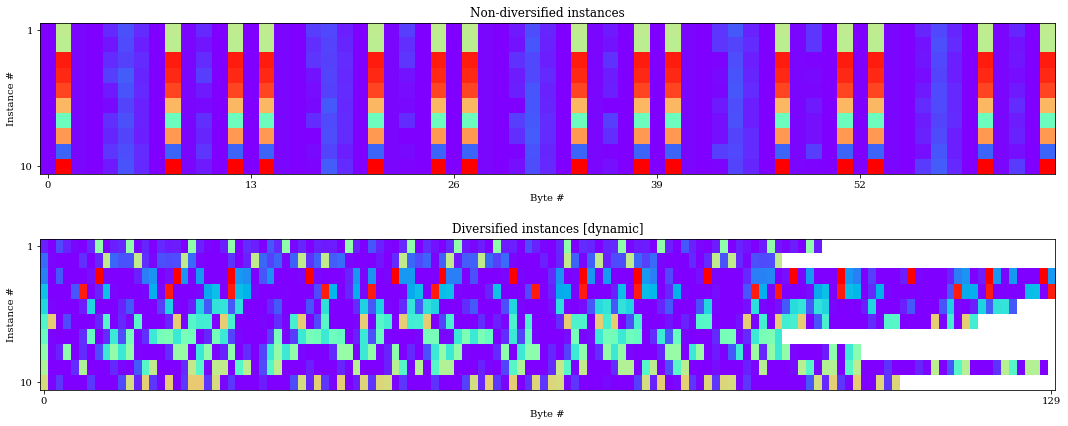

In [8]:
plot_two_images(1, mask_nan(base_data), mask_nan(diversified_data))
plt.savefig('picture_raw_bytes.png', dpi=300)

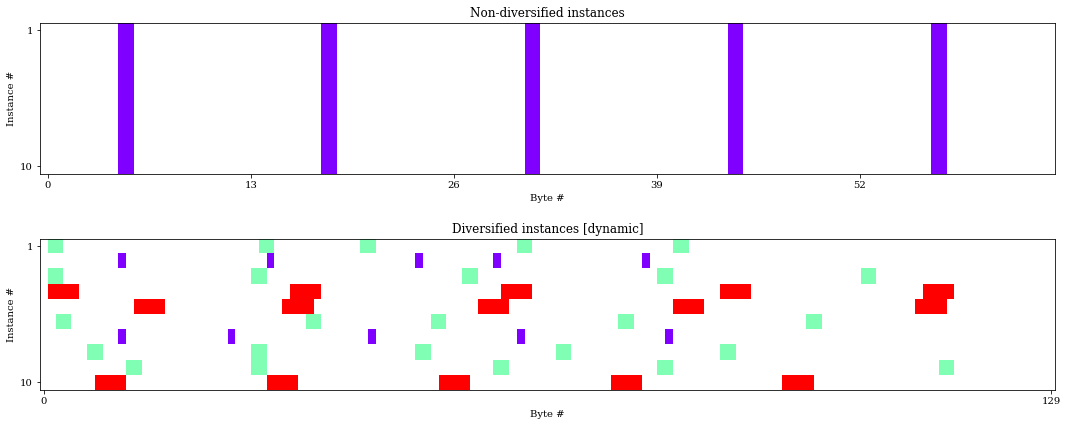

In [9]:
base_weak_type = np.ma.masked_where(base_weak < 1, base_type)

diversified_weak_type = diversified_weak.copy()
diversified_weak_type[np.isnan(diversified_weak_type)] = 0
diversified_weak_type = np.ma.masked_where(diversified_weak_type < 1, diversified_type)

plot_two_images(2, base_weak_type, diversified_weak_type)
plt.savefig('picture_weak_param.png', dpi=300)